In [1]:
import jax  # Autodiff, easy batching of functions
import jax.numpy as jnp  # Like numpy but written to run fast on GPU
import numpy as np
import distrax  # Tensorflow probability for Jax
import haiku as hk  # Used for making neural nets
import tqdm  # Used for reporting training progress
import chex  # Used for checking dimensions, useful for debugging
from jax.scipy.linalg import cholesky  # Need to structure covariance appropriately for learning
from matplotlib import pyplot as plt
from functools import partial
from matplotlib import pyplot as plt
import optax  # Used for optimization using SGD, Adam etc

# plt.style.use('seaborn-v0_8-deep')

%matplotlib inline

- test that our KL function matches the built-in KL function for a single Gaussian

In [161]:
ACTION_DIM = 10
STATE_DIM = 2
batch_size = 500

In [301]:
def transform_to_cov(sq_mat):
    return jnp.dot(sq_mat.T, sq_mat)


@jax.jit
def normal_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MultivariateNormalTri(
        loc=jnp.array(prior_params['loc']), scale_tri=jnp.exp(prior_params['scale'])
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@jax.jit
def mixture_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))

  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])),
        )

  dist_model = distrax.MultivariateNormalTri(
      loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
      )

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model + log_probs_prior

@partial(jax.jit, static_argnums=(2,))
def policy_sample(rng, params, num_samples):
  """See policy log prob."""
  samples = distrax.MultivariateNormalTri(
      loc=params['loc'],
      scale_tri=jnp.exp(params['scale'])
      ).sample(seed=rng, sample_shape=(num_samples,))
  chex.assert_shape(samples, (num_samples, ACTION_DIM))

  return samples

# @partial(jax.jit, static_argnums=(2,))
# def univariate_policy_sample(rng, params, num_samples):
#   mu = jnp.array(params['loc'])
#   sigma = jnp.exp(jnp.array(params['scale']))

#   eps = 1e-4
#   samples = distrax.Normal(loc=mu, scale=sigma).sample(seed=rng, sample_shape=(num_samples,)).reshape(-1)
#   chex.assert_shape(samples, (num_samples,))

#   return samples

# def loss_fn(params, actions, rewards, prior_params):
#   chex.assert_shape(actions, (batch_size,ACTION_DIM))
#   chex.assert_shape(rewards, (batch_size,))
#   # log_probs = normal_policy_log_prob(params, actions, prior_params)
#   log_probs = mixture_policy_log_prob(params, actions, prior_params)
#   chex.assert_shape(log_probs, (batch_size,))
#   rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
#   return -(rewards * log_probs).sum()

# def kl_penalty_dumb(params, prior_params):
#   dist_prior = distrax.MixtureSameFamily(
#         mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
#         components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"][0],scale_tri=jnp.exp(prior_params["scales"][0])),
#         )
    
#   dist_model = distrax.MultivariateNormalTri(
#       loc=jnp.array(params['loc']), scale_tri=jnp.exp(params['scale'])
#       )
  
#   penalty = 0
#   for weight, component in zip(dist_prior.mixture_distribution.probs, dist_prior.components_distribution):
#     penalty += component.kl_divergence(dist_model)*weight

#   return penalty

@partial(jax.jit, static_argnums=(3,))
def kl_penalty(rng_key, params, prior_params, n_samples=500):
    # Measures the information gain achieved if target probability distribution would be used instead of predicted probability distribution.
    dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])))

    dist_policy = distrax.MultivariateNormalTri(
        loc=params['loc'],
        scale_tri=jnp.exp(params['scale']))
    
    # # This is one way!
    # # sample from the prior, this is what we're taking the expectation under!
    prior_samples = dist_prior.sample(seed=rng_key, sample_shape=(n_samples,))
    # # get log probs under the prior and policy  
    prior_x = dist_prior.log_prob(prior_samples)
    policy_x = dist_policy.log_prob(prior_samples)
    return jnp.mean(prior_x - policy_x)

    # # This is the other way
    # # sample from the policy, this is what we're taking the expectation under!
    # policy_samples = dist_policy.sample(seed=rng_key, sample_shape=(n_samples,))
    # # get log probs under the prior and policy  
    # prior_x = dist_prior.log_prob(policy_samples)
    # policy_x = dist_policy.log_prob(policy_samples)
    # return jnp.mean(policy_x - prior_x)

def loss_fn(params, actions, rewards, divergence, prior_params, alpha):
  chex.assert_shape(actions, (batch_size,ACTION_DIM))
  chex.assert_shape(rewards, (batch_size,))
  # log_probs = normal_policy_log_prob(params, actions, prior_params)
  log_probs = mixture_policy_log_prob(params, actions, prior_params)
  chex.assert_shape(log_probs, (batch_size,))
  rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
  # larger -log_prob = smaller probability 
  # larger divergence = further from prior?
  kl = alpha*divergence
  loss = -(rewards * log_probs).sum() + kl
  return loss

@jax.jit
def get_rewards(a, target_params, decoder):
  # sample from target distribution, then find distances
  # model = distrax.MultivariateNormalTri(loc=model_params_['loc'], scale_tri=model_params_['scale'])
  # target_samples = target_dist.sample(seed=key, sample_shape=(a.shape[0],))
  # return -jnp.sum(jnp.subtract(a, target_samples)**2,axis=1)

  # subtract from target distribution mean
  # e^-root(2) --> 1
  # 0.24 --> 1
  return jnp.exp(-jnp.sum(jnp.subtract(a @ decoder.T, target_params["loc"])**2,axis=1))

@jax.jit  # This compiles the function to the GPU
def update_fn(params, actions, rewards, divergence, opt_state, prior_params, alpha, wlr=1e-4, epsilon=1e-8):
  optimizer = optax.adam(wlr)
  loss = loss_fn(params, actions, rewards, divergence, prior_params, alpha)
  grads = jax.grad(loss_fn)(params, actions, rewards, divergence, prior_params, alpha)
  # scale = params["scale"]
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  # params["scale"] = scale
  # params['scale'] = jnp.clip(params['scale'], a_min=epsilon)  # Clip for numerical stability
  return params, opt_state, loss

In [302]:
SIGMA = 0.01
def setup_params():
    # manually make the prior
    # prior_probs = jnp.array([0.5,0.5])
    prior_probs = jnp.array([1.0])
    prior_means = np.zeros((ACTION_DIM))
    prior_means = jnp.array(prior_means)
    prior_covs = [np.eye(ACTION_DIM)*SIGMA]
    prior_covs = jnp.array(prior_covs)
    prior_scales = jnp.linalg.cholesky(jnp.array(prior_covs))
    prior_params = {
        "prior_probs" : jnp.log(prior_probs),
        "means" : prior_means,
        "scales" : jnp.log(prior_scales)
    }


    # test for KL
    # gaussian_prior_probs = jnp.array([1.0])
    # gaussian_prior_means = jnp.array([jnp.array([5.,0.])])
    # gaussian_prior_scales = jnp.linalg.cholesky(jnp.array([np.eye(STATE_DIM)]))
    # gaussian_prior_params = {
    #     "prior_probs" : jnp.log(gaussian_prior_probs),
    #     "means" : gaussian_prior_means,
    #     "scales" : jnp.log(gaussian_prior_scales)
    # }


    starting_mean = jnp.zeros((ACTION_DIM))
    # starting_mean = jnp.array(starting_mean)
    starting_scale = jnp.linalg.cholesky(jnp.eye(ACTION_DIM)*SIGMA)
    params = {
        'loc': starting_mean,
        'scale': jnp.log(starting_scale)
        }

    target_position = jnp.array([1.,0.])
    target_scale = jnp.linalg.cholesky(jnp.eye(STATE_DIM)*SIGMA)
    target_params = {
        'loc': target_position,
        'scale': jnp.log(target_scale)
    }
    return prior_params, params, target_params

def plot_samples(dist,num_samples,label,rng, decoder=None):
  # split for new samples
  samples = dist.sample(seed=rng, sample_shape=(num_samples,)).T
  if decoder is None:
    plt.scatter(samples[0],samples[1],label=label)
  else:
    samples = decoder @ samples
    plt.scatter(samples[0],samples[1],label=label)
     

def make_target_dist(target_params):
    return  distrax.MultivariateNormalTri(
    loc=target_params['loc'],
    scale_tri=jnp.exp(target_params['scale']))

def make_prior_dist(prior_params):
   return distrax.MixtureSameFamily(
    mixture_distribution = distrax.Categorical(probs=jnp.exp(prior_params["prior_probs"])),
    components_distribution = distrax.MultivariateNormalTri(loc=prior_params["means"],scale_tri=jnp.exp(prior_params["scales"])))

def make_starting_dist(starting_params):
    return distrax.MultivariateNormalTri(
    loc=starting_params['loc'],
    scale_tri=jnp.exp(starting_params['scale']))
   

### test KL

In [303]:
key = jax.random.PRNGKey(0)

prior_params, params, target_params = setup_params()

prior_dist = make_prior_dist(prior_params)


prior_means = jnp.zeros((ACTION_DIM))
prior_covs = [np.eye(ACTION_DIM)*0.01]
prior_covs[-1][:2,:2] = np.array([[5.0,0.0],
                                    [0.0,5.0]])
prior_covs = jnp.array(prior_covs)
prior_scales = jnp.linalg.cholesky(jnp.array(prior_covs))
kl_test_params = {
    "loc" : prior_means,
    "scale" : jnp.log(prior_scales)
}

target_dist = make_target_dist(kl_test_params)
key, subkey = jax.random.split(key)
print(kl_penalty(subkey, kl_test_params, prior_params, n_samples=500))
print(prior_dist.components_distribution[0].kl_divergence(target_dist))
print(target_dist.kl_divergence(prior_dist.components_distribution[0]))

5.2111597
[5.216609]
[492.7855]


In [310]:
prior_params, params, target_params = setup_params()
num_iter = 2000
learning_rate = 1e-3
opt_state = optax.adam(learning_rate).init(params)
losses = np.zeros(num_iter)
rewards = np.zeros(num_iter)
divergences = np.zeros(num_iter)
params_list = []

# the starting key
key = jax.random.PRNGKey(0)

# key, subkey = jax.random.split(key)
# decoder = jax.random.normal(subkey,shape=(STATE_DIM,ACTION_DIM))

decoder = np.zeros((STATE_DIM,ACTION_DIM))
decoder[:2,:2] = np.array([[1,0],[0,1]])
decoder = jnp.array(decoder)

params_list.append(params)
for t in tqdm.tqdm(range(num_iter)):
  # split key for policy sample
  key, subkey = jax.random.split(key)
  actions_t = policy_sample(params=params, num_samples=batch_size, rng=subkey)
  rewards_t = get_rewards(actions_t, target_params, decoder)
  rewards[t] = rewards_t.mean()
  # split key for KL penalty
  key, subkey = jax.random.split(key)
  divergence_t = kl_penalty(subkey, params, prior_params)
  divergences[t] = divergence_t
  params, opt_state, loss_t = update_fn(params, actions_t, rewards_t, divergence_t, opt_state, prior_params=prior_params, alpha=0.0, wlr=learning_rate)
  losses[t] = loss_t
  params_list.append(params)
means = np.array([[p["loc"][0],p["loc"][1]] for p in params_list]).T

100%|██████████| 2000/2000 [00:05<00:00, 337.41it/s]


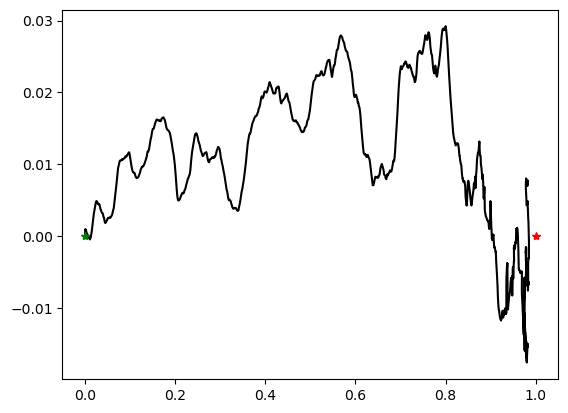

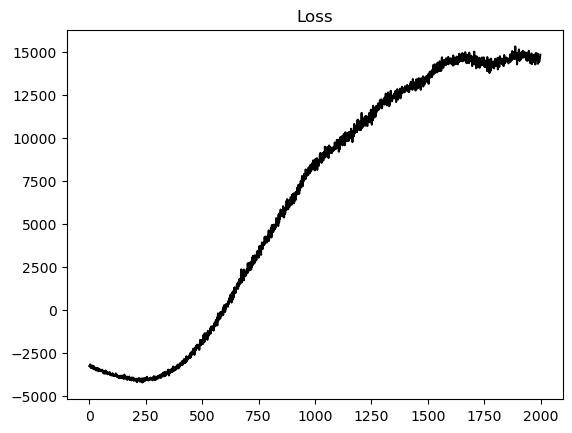

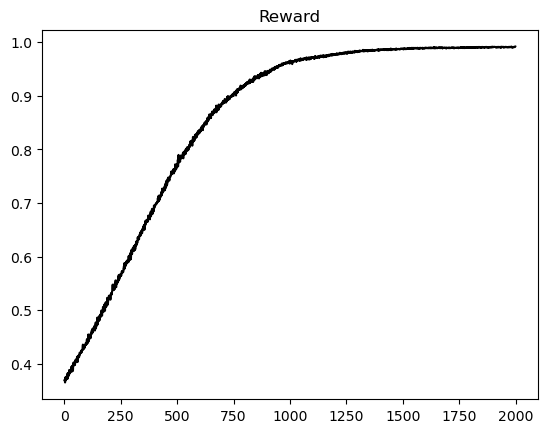

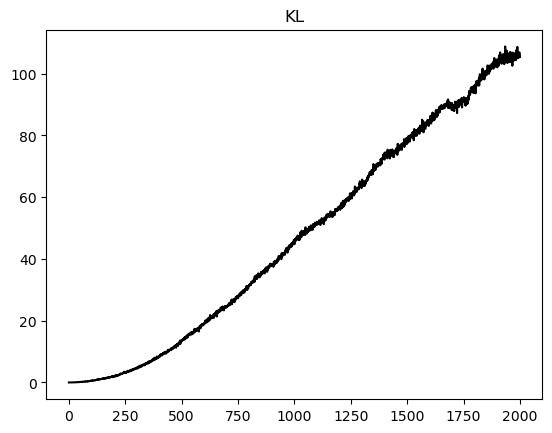

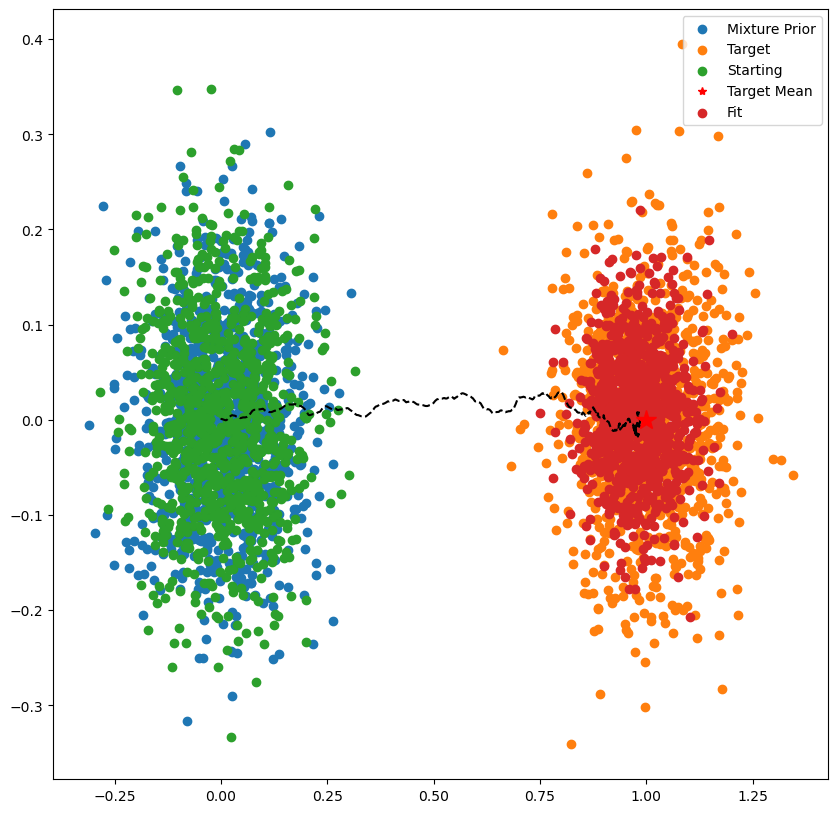

In [311]:
# def plot_2d_dist(dist):
#   xl = jnp.linspace(-20,20,100)
#   yl = jnp.linspace(-20,20,100)
#   x, y = jnp.meshgrid(xl, yl)
#   X = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
#   probs = dist.prob(X).reshape((101, 101))
#   left,right,bottom,top = xl.min(), xl.max(), yl.min(), yl.max()
#   plt.imshow(probs, extent=(left,right,bottom,top), origin="lower")
#   _ = plt.gca().set_xticks(xl[::10],labels=np.round(xl[::10]),rotation=45)
#   _ = plt.gca().set_yticks(yl[::10],labels=np.round(yl[::10]),rotation=45)

plt.figure()
plt.plot(means[0],means[1],"k-")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*")
plt.plot(params_list[0]["loc"][0],params_list[0]["loc"][1],"g*")

plt.figure()
plt.plot(losses,"k-")
plt.title("Loss")

plt.figure()
plt.plot(rewards,"k-")
plt.title("Reward")

plt.figure()
plt.plot(divergences,"k-")
plt.title("KL")

plt.figure(figsize=(10,10))
plt.gca().set_aspect("auto")

key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key)
plot_samples(make_prior_dist(prior_params),1000,"Mixture Prior",rng=subkey,decoder=decoder)
key, subkey = jax.random.split(key)
plot_samples(make_target_dist(target_params),1000,"Target",rng=subkey)
key, subkey = jax.random.split(key)
plot_samples(make_starting_dist(params_list[0]),1000,"Starting",rng=subkey,decoder=decoder)
key, subkey = jax.random.split(key)
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",label="Target Mean")

# middle_dist = distrax.MultivariateNormalTri(
#     loc=params_list[500]['loc'],
#     scale_tri=jnp.exp(params_list[500]['scale']),
#     )
# plot_samples(middle_dist,1000,"Middle",key)

# late_dist = distrax.MultivariateNormalTri(
#     loc=params_list[-100]['loc'],
#     scale_tri=jnp.exp(params_list[-100]['scale']),
#     )
# plot_samples(late_dist,1000,"Late",key)

key, subkey = jax.random.split(key)
fitted_dist = distrax.MultivariateNormalTri(
    loc=params_list[-1]['loc'],
    scale_tri=jnp.exp(params_list[-1]['scale']),
    )
plot_samples(fitted_dist,1000,"Fit",subkey,decoder=decoder)

plt.plot([p["loc"][0] for p in params_list],[p["loc"][1] for p in params_list],"k--")
plt.plot(target_params["loc"][0],target_params["loc"][1],"r*",markersize=15)

plt.legend()

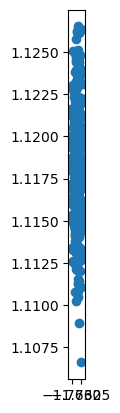

In [295]:
key, subkey = jax.random.split(key)
fitted_dist = distrax.MultivariateNormalTri(
    loc=params_list[-1]['loc'][:2],
    scale_tri=jnp.exp(params_list[-1]['scale'][:2,:2]),
    )
# plot_samples(fitted_dist,1000,"Fit",subkey,decoder=decoder)
samples = fitted_dist.sample(seed=subkey, sample_shape=(500,)).T[:2,:]
plt.scatter(samples[0],samples[1],label="Fit")
plt.gca().set_aspect("equal")